PreRequisites
---
Lambda GPUs provides completely ephemeral environments. So the instances need to be set up from scratch every single time you end up using one. This notebook is meant to make the setup fairly automated and fast. But there are some manual steps that need to be executed on the shell first.

Need to manually install python into vscode. Execute the commands below to bootstrap the notebook.
~~~
sudo apt update
sudo apt install python3-pip git
git config --global credential.helper store
huggingface-cli login
~~~

Manual steps:
 - Also ssh to git@github.com first
 - huggingface-cli login

In [19]:
import sys, os
from pathlib import Path

# For LambdaVMs we want to keep the cache on the persistent filesystem
mount_dir=Path('/home/ubuntu/niels-data')

cache_dir = mount_dir / 'cache'
hub_dir = mount_dir / 'cache/huggingface/hub'
os.makedirs(hub_dir, exist_ok=True)
os.environ['TORCH_HOME'] = str(cache_dir)
os.environ['HF_DATASETS_CACHE'] = str(cache_dir)
os.environ['HUGGINGFACE_HUB_CACHE'] = str(hub_dir)
path = f'{os.environ["PATH"]}:{os.path.expanduser("~/.local/bin")}'
os.environ['PATH'] = path

Get dependencies for the project
---

In [ ]:
%cd /home/ubuntu/niels-data
!git clone --recurse-submodules git@github.com:provos/stable-diffusion-finetuning.git
%cd stable-diffusion-finetuning
!pip install --upgrade pip
!pip install -r requirements.txt

!pip install --upgrade keras # on lambda stack we need to upgrade keras

Cache the big CLIP model that usually fails to download
---
You may need to run this for a few times until everything was downloaded; that's what the resume_download is for.

In [ ]:
from huggingface_hub import scan_cache_dir, hf_hub_download
from datasets import load_dataset

# cache big clip model
hf_cache_info = scan_cache_dir()
hf_hub_download(repo_id="openai/clip-vit-large-patch14", filename="pytorch_model.bin", resume_download=True)

# cache dataset
directory = './twitterdownloader/data/labeled/'
dataset = load_dataset("imagefolder", data_dir=directory, split="train")

Check whether our own data can be loaded and makes sense. This uses the `imagefolder` producer as the dataset is not published to huggingface.

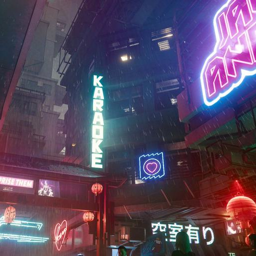

a neon sign that says karaoke in a dark city at night time with neon lights


In [4]:
sample = dataset[0]
display(sample["image"].resize((256, 256)))
print(sample["text"])

Download the stable-diffusion 1.4 model - requires working huggingface login; see above

In [8]:
ckpt_path = hf_hub_download(repo_id="CompVis/stable-diffusion-v-1-4-original", filename="sd-v1-4-full-ema.ckpt", use_auth_token=True, resume_download=True)

Downloading:   0%|          | 0.00/7.70G [00:00<?, ?B/s]

In [9]:
# 2xA6000 or whatever you are actually able to rent; LambdaGPU is mostly unavailable.
BATCH_SIZE = 4
N_GPUS = 2
ACCUMULATE_BATCHES = 1

gpu_list = ",".join((str(x) for x in range(N_GPUS))) + ","
print(f"Using GPUs: {gpu_list}")

Using GPUs: 0,1,


In [20]:
# Run training
cmd = f'python3 main.py \
    -t \
    --base configs/stable-diffusion/cyberpunk.yaml \
    --gpus "{gpu_list}" \
    --scale_lr False \
    --num_nodes 1 \
    --check_val_every_n_epoch 2 \
    --finetune_from "{ckpt_path}" \
    data.params.batch_size="{BATCH_SIZE}" \
    lightning.trainer.accumulate_grad_batches="{ACCUMULATE_BATCHES}" \
    data.params.validation.params.n_gpus="{N_GPUS}"'
print(f'Running {cmd}')
!{cmd}
     

Running python3 main.py     -t     --base configs/stable-diffusion/cyberpunk.yaml     --gpus "0,1,"     --scale_lr False     --num_nodes 1     --check_val_every_n_epoch 10     --finetune_from "/home/ubuntu/niels-data/cache/huggingface/hub/models--CompVis--stable-diffusion-v-1-4-original/snapshots/f0bb45b49990512c454cf2c5670b0952ef2f9c71/sd-v1-4-full-ema.ckpt"     data.params.batch_size="4"     lightning.trainer.accumulate_grad_batches="1"     data.params.validation.params.n_gpus="2"
Global seed set to 23
Running on GPUs 0,1,
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Downloading: "https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty_with_aug/checkpoint_liberty_with_aug.pth" to /home/ubuntu/niels-data/cache/hub/checkpoints/checkpoint_libert